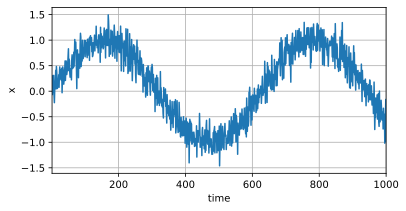

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T=1000
time=torch.arange(1,T+1,dtype=torch.float32)
x=torch.sin(0.01*time)+torch.normal(0,0.2,(T,))
d2l.plot(time,[x],'time','x',xlim=[1,T],figsize=(6,3))

In [2]:
tau=4
features=torch.zeros((T-tau,tau))
for i in range(tau):
    features[:,i]=x[i:T-tau+i]
labels=x[tau:T].reshape(-1,1)
batch_size,n_train=16,600
train_iter=d2l.load_array((features[:n_train],labels[:n_train]),batch_size=batch_size,is_train=True)

In [3]:
def init_weight(m):
    if type(m)==nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    
def get_net():
    net=nn.Sequential(nn.Linear(tau,10),nn.ReLU(),
                      nn.Linear(10,1))
    net.apply(init_weight)
    return net

loss=nn.MSELoss(reduction='none')

In [4]:
def train(net,train_iter,num_epochs,loss,lr):
    updater=torch.optim.Adam(net.parameters(),lr)
    for epoch in range(num_epochs):
        for X,y in train_iter:
            updater.zero_grad()
            l=loss(net(X),y)
            l.sum().backward()
            updater.step()
        print(f'epoch:{epoch+1},',f"loss:{d2l.evaluate_loss(net,train_iter,loss):f}")

net=get_net()
train(net,train_iter,5,loss,0.01)

epoch:1, loss:0.053733
epoch:2, loss:0.052869
epoch:3, loss:0.056539
epoch:4, loss:0.054535
epoch:5, loss:0.048846


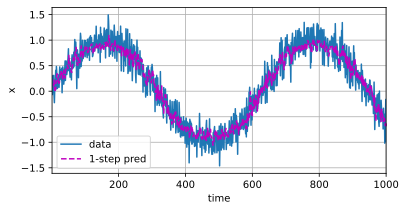

In [5]:
onestep_preds=net(features)
d2l.plot([time,time[tau:]],[x.detach().numpy(),onestep_preds.detach().numpy()],'time','x',
         legend=['data','1-step pred'],xlim=[1,1000],
         figsize=(6,3))

In [10]:
features[:,1].shape

torch.Size([996])

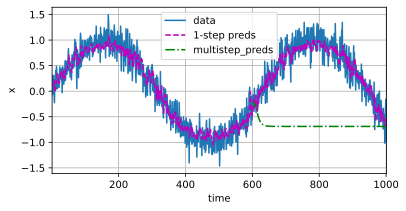

In [13]:
multistep_preds=torch.zeros(T)
multistep_preds[:n_train+tau]=x[:n_train+tau]
for i in range(n_train+tau,T):
    multistep_preds[i]=net(multistep_preds[i-tau:i].reshape(1,-1))
d2l.plot([time,time[tau:],time[n_train+tau:]],
        [x.detach().numpy(),onestep_preds.detach().numpy(),multistep_preds[n_train+tau:].detach().numpy()],
        'time','x',legend=['data','1-step preds','multistep_preds'],
         xlim=[1,T+1],figsize=(6,3))

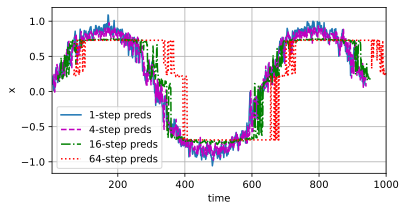

In [14]:
max_steps=64
#前tau个特征是观测得到的数据，后面的特征是通过net网络预测得到的，features的第tau+i列是第i步预测得到的值
#所以features一共有tau+max_steps列，其中最后一列不用做特征，其他的每一列都是由他们前的tau列特征求出来的
#所以行数为(T-1)-(tau+max_steps-1)+1    :最后一行的最后一列下标 — 第一行最后一列下标 + 1
features=torch.zeros((T-tau-max_steps+1,tau+max_steps))  
for i in range(tau):
    features[:,i]=x[i:T-tau-max_steps+1+i]
for i in range(tau,tau+max_steps):
    features[:,i]=net(features[:,i-tau:i]).reshape(-1)

step=1,4,16,64
d2l.plot([time[tau+i-1:T-max_steps+i] for i in step],
         [features[:,tau+i-1].detach().numpy() for i in step],
         'time','x',legend=[f"{i}-step preds" for i in step],xlim=[4,T],
         figsize=(6,3)
        )